# Fit Analysis

- Gabriel Wendell Celestino Rocha
- Leonardo Andrade de Almeida

---

## 0. Setup

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.font_manager import FontProperties

import seaborn as sns
from scipy.optimize import minimize
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

- ### Aesthetic Functions

In [2]:
%matplotlib inline

cm_font = FontProperties(fname  = 'CutiveMono-Regular.ttf')
gs_font = FontProperties(fname  = 'GillSans-Light.otf')
cm_size = 20


###############
# SINGLE PLOT #
###############
def sm_plot(grid = True, dark_background = False, use_tex = False, font_family = 'monospace', font_size = 15, 
            minorticks = True, major_ticks = True, minor_ticks = True, grid_linestyle = ':', grid_color = '0.50', 
            tick_length_minor = 5, tick_width_minor = 1, tick_length_major = 8, tick_width_major = 1, labelsize = 15):
    """
    Function to improve the aesthetics of Matplotlib graphs.
    """
    if dark_background:
        plt.style.use('dark_background')
    
    if grid:
        plt.grid(True, linestyle = grid_linestyle, color = grid_color, zorder = 0)
    else:
        plt.grid(False)
    
    plt.rcParams['text.usetex'] = use_tex
    plt.rcParams['font.family'] = font_family
    plt.rcParams['font.size'] = font_size
    
    if minorticks:
        plt.minorticks_on()
    else:
        plt.minorticks_off()
    
    if minor_ticks:
        plt.tick_params(axis = 'both', which = 'minor', direction = "in", 
                        top = True, right = True, length = tick_length_minor, 
                        width = tick_width_minor, labelsize = labelsize)
    
    if major_ticks:
        plt.tick_params(axis = 'both', which = 'major', direction = "in", 
                        top = True, right = True, length = tick_length_major, 
                        width = tick_width_major, labelsize = labelsize)
        
        
# ----------------------------------------------------------------------------------------------------------


###############
## PLOT AXES ##
###############
def sm_plot_mod(ax, grid = True, dark_background = False, use_tex = False, font = 'monospace', font_size = 15, 
                minor_ticks = True, minor_tick_params = True, major_tick_params = True):
    
    if dark_background:
        plt.style.use('dark_background')
    else:
        plt.style.use('default')

    ax.grid(grid, linestyle = ':', color = '0.50')
    
    plt.rcParams['font.family'] = font
    plt.rcParams['font.size'] = font_size
    
    plt.rcParams['text.usetex'] = use_tex
    
    if minor_ticks:
        ax.minorticks_on()
    else:
        ax.minorticks_off()

    if minor_tick_params:
        ax.tick_params(axis = 'both', which = 'minor', direction = "in", 
                       top = True, right = True, length = 5, width = 1, labelsize = font_size)

    if major_tick_params:
        ax.tick_params(axis = 'both', which = 'major', direction = "in", 
                       top = True, right = True, length = 8, width = 1, labelsize = font_size)

---

## 1. Loading data

The master dataframe consists of the union of the two datasets presented above. It is also important to reorganize the data so that it is indexed based on the galaxy analyzed (NGC number). The base-$10\log$ of the period for each Cepheid is also calculated.

In [3]:
data_path = '../data/'
df_path = data_path + 'R11treat.dat'

df = pd.read_csv(df_path, sep = '	', skiprows = 8)
print('DATAFRAME MASTER =D')
display(df)

print('---------------------')
print('  SHAPE =', df.shape)
print('---------------------')

info_path = data_path + 'R11treat_info.txt'

with open(info_path, 'r') as file:
    info = file.read()

print(info)

DATAFRAME MASTER =D


,id,gal,z,dL,M,Merr,m,merr,P,logP,logO_H,bias,Pivot
0,27185,4536,0.006031,25.847143,-7.549763,0.31,24.5123,0.31,13.000,1.113943,-3.46,0.13,1.474125
1,42353,4536,0.006031,25.847143,-6.071363,0.74,25.9907,0.74,13.070,1.116276,-3.03,0.37,1.474125
2,50718,4536,0.006031,25.847143,-7.912863,0.42,24.1492,0.42,13.730,1.137671,-3.36,0.28,1.474125
3,72331,4536,0.006031,25.847143,-7.586963,0.44,24.4751,0.44,13.910,1.143327,-3.19,0.22,1.474125
4,65694,4536,0.006031,25.847143,-7.203863,0.38,24.8582,0.38,14.380,1.157759,-3.10,0.39,1.474125
...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,29163,4258,0.001494,6.402857,-4.879869,0.57,24.1520,0.57,6.739,0.828595,-3.25,0.38,1.474125
642,34729,4258,0.001494,6.402857,-6.371069,0.50,22.6608,0.50,14.920,1.173769,-3.25,0.00,1.474125
643,89375,4258,0.001494,6.402857,-6.619069,0.45,22.4128,0.45,12.380,1.092721,-3.11,0.42,1.474125
644,246695,4258,0.001494,6.402857,-6.434969,0.40,22.5969,0.40,11.200,1.049218,-3.11,0.49,1.474125


---------------------
  SHAPE = (646, 13)
---------------------

# R11treat.dat
#
# This is a processed and treated version of the Cepheid and redshift datas from R11.
# (Riess et al. 2011 [R11], ApJ, 730, 119, Table 2)
#
# Columns:
#      id: the ID of the cepheid
#     gal: the NGC number of the host galaxy
#       z: redshift of the host galaxy
#      dL: the distance computed via Hubble's law
#       M: abs mags M are computed using M = m + 5*log10(dL/Mpc) + 25
#    Merr: abs mags errs are just the mags m errs
#       m: mags m are computed using m = F160W - 0.41*(V_I)
#    merr: mag errs are just those in the F160W mags
#          (errors in V-I were not given in R11)
#       P: period P is in days (errors in the Period were not given)
#    logP: base-10log of the period for each Cepheid
#  logO_H: this is actually log[O/H], not 12 + log[O/H] as in R11
#    bias: this is the crowding bias *already applied* by R11
#
# Notes:
# - cepheid with id 102255 was excluded since its mag err

---

## 2. Correlation Analysis

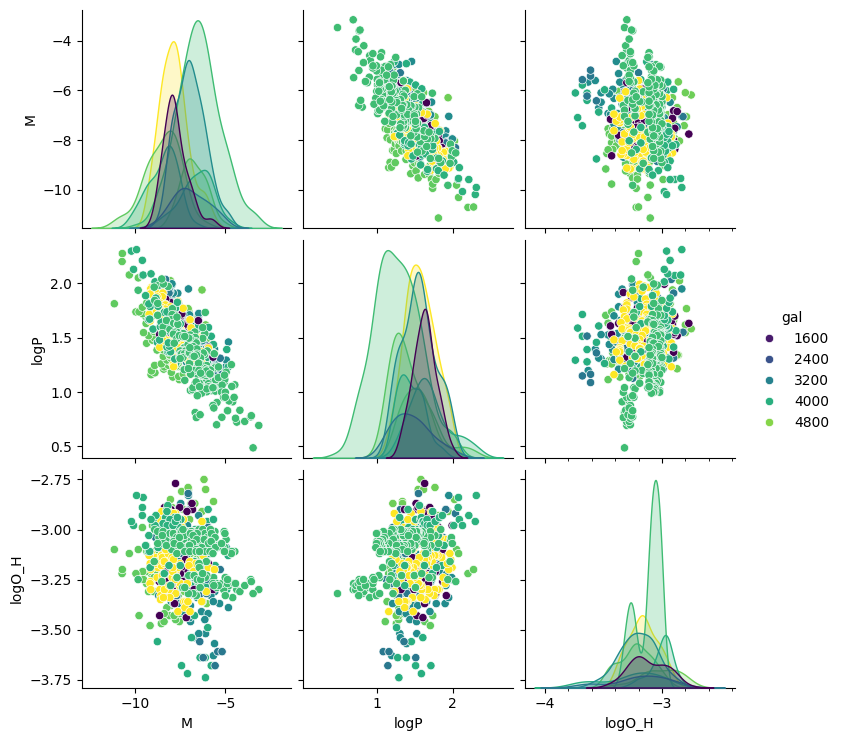

In [4]:
sns.pairplot(df, hue = 'gal', palette = 'viridis',
             x_vars = ['M', 'logP', 'logO_H'], y_vars = ['M', 'logP', 'logO_H'])
sm_plot()

---

## 3. Fits Attempts

### 3.1 Linear Fit

In [27]:
def meanfunc(x, a, b):
    return a + b * (x - global_pivot)

param_names = ['a', 'b', 'sigma']
param_labels = [r'$a$', r'$b$', r'$\sigma$']

global_pivot = df['logP'].mean()
df['Pivot'] = global_pivot

xx = np.linspace(df['logO_H'].min(), df['logO_H'].max(), len(df['Pivot']))
params, covariance = curve_fit(meanfunc, df['logO_H'], df['M'], p0 = [0, 0])
a_opt, b_opt = params

param_errors = np.sqrt(np.diag(covariance))
a_std, b_std = param_errors

# -----------------------------------------------------------------------------------------

Res = df['M'] - meanfunc(xx, a_opt, b_opt)

n = len(df)
# Number of predictors
p = 1  # Only 'logO_H' is the predictor in this case
ss_res = np.sum(Res ** 2)
rse = np.sqrt(ss_res / (n - p - 1))

print(f"Residual Standard Error (RSE): {rse}")

Residual Standard Error (RSE): 1.3127875204717079


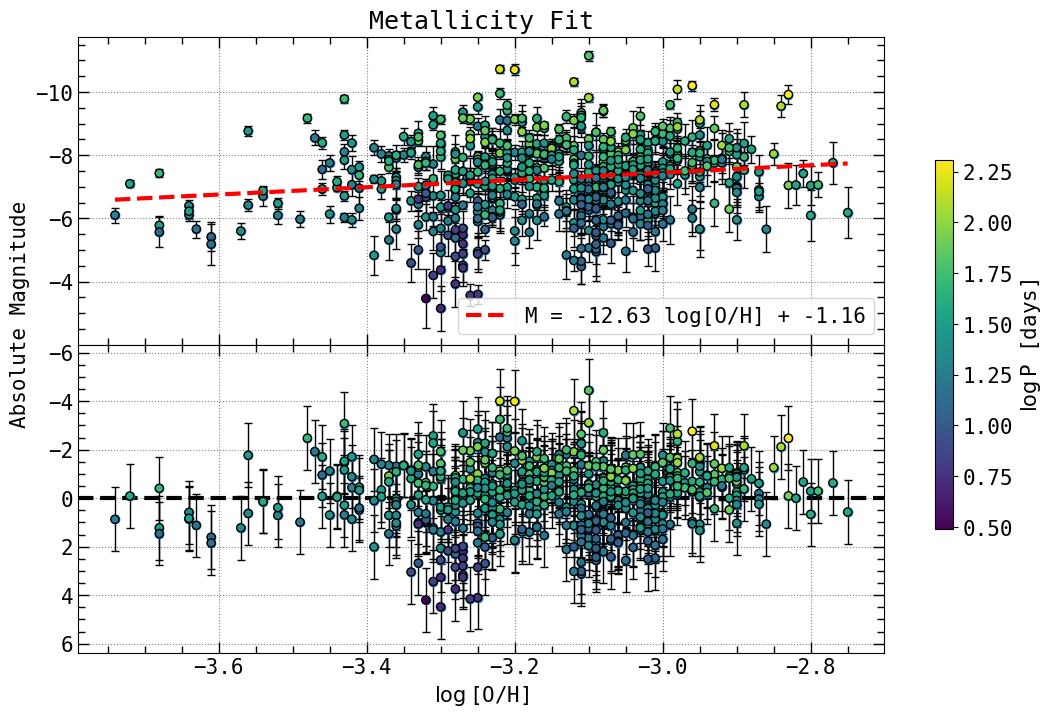

In [35]:
# Plotting
fig, axs = plt.subplots(2, 1, figsize = (13,8), sharex = True)
fig.subplots_adjust(hspace = 0)

sc1 = axs[0].scatter(df['logO_H'], df['M'], c = df['logP'], cmap = 'viridis', s = 35, edgecolor = 'k', zorder = 3)
axs[0].errorbar(df['logO_H'], df['M'], yerr = df['Merr'], fmt = 'o', 
                ecolor = 'k', elinewidth = 1, zorder = 2, capsize = 3, lw = 1)
axs[0].plot(xx, meanfunc(xx, a_opt, b_opt), ls = '--', lw = 3, color = 'r', zorder = 4, 
            label = 'M = {:.2f} log[O/H] + {:.2f}'.format(a_opt, b_opt))


sc2 = axs[1].scatter(df['logO_H'], Res, c = df['logP'], cmap = 'viridis', s = 35, edgecolor = 'k', zorder = 3)
axs[1].axhline(0, color = 'black', ls = '--', lw = 3)
axs[1].errorbar(df['logO_H'], Res, yerr = rse, fmt = 'o', 
                ecolor = 'k', elinewidth = 1, zorder = 2, capsize = 3, lw = 1)

cbar1 = fig.colorbar(sc1, ax = axs[:,], shrink = 0.6)
cbar1.set_label(r'$\log$P [days]')

axs[1].set_xlabel(r'$\log$[O/H]')
axs[0].set_ylabel('Absolute Magnitude', y = +0.1)
axs[0].set_title('Metallicity Fit')

axs[0].invert_yaxis()
axs[1].invert_yaxis()  
axs[0].legend(loc = 'best')
sm_plot_mod(axs[0])
sm_plot_mod(axs[1])